In [1]:
from keras import Model
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Dense, LSTM, Embedding, GRU, Flatten, Dropout, BatchNormalization, RepeatVector, concatenate
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import coco_parse
import flickr8k_parse
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import text_processing

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_vocab = text_processing.Vocabulary()
train_vocab.load_vocabulary()

In [3]:
batch_size = 16

initial_state_size = 512
embedding_out_size = 512
number_of_gru = 2
batch_norm = False
dropout = False
path_checkpoint = './decoders/VGG16_GRU_flickr8k_2l_16b.hdf5'

In [4]:
### Encoder input part
encoder_input = Input(shape=(4096,), name='encoder_input')
encoder_reduction = Dense(initial_state_size, activation='relu', name='encoder_reduction')
if batch_norm:
    bn1 = BatchNormalization()
### Decoder input and embedding
decoder_input = Input(shape=(None,), name='decoder_input')
embedding = Embedding(input_dim=train_vocab.number_of_words, output_dim=embedding_out_size, name='embedding')
if dropout:
    drop1 = Dropout(0.5)
### GRU1
gru1 = GRU(initial_state_size, name='GRU1', return_sequences=True)
if batch_norm:
    bn2 = BatchNormalization()
### GRU2    
if number_of_gru >= 2:
    gru2 = GRU(initial_state_size, name='GRU2', return_sequences=True)
    if batch_norm:
        bn3 = BatchNormalization()
### GRU3        
if number_of_gru == 3:
    gru3 = GRU(initial_state_size, name='GRU3', return_sequences=True)
    if batch_norm:
        bn4 = BatchNormalization()

decoder_dense = Dense(train_vocab.number_of_words, activation='softmax', name='decoder_output')

def connect_transfer_values(transfer_values):
    
    initial_state = encoder_reduction(transfer_values)
    if batch_norm:
        initial_state = bn1(initial_state)

    X = decoder_input
    X = embedding(X)
    if dropout:
        X = drop1(X)
    
    X = gru1(X, initial_state=initial_state)
    if batch_norm:
        X = bn2(X)
    if number_of_gru >= 2:
        X = gru2(X, initial_state=initial_state)
        if batch_norm:
            X = bn3(X)
    if number_of_gru == 3:
        X = gru3(X, initial_state=initial_state)
        if batch_norm:
            X = bn4(X)

    decoder_output = decoder_dense(X)
    
    return decoder_output

In [5]:
transfer_values = np.load('./cnn_features/vgg16_flickr8k_train.npy')

In [6]:
optimizer = RMSprop(lr=1e-3)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
decoder_output = connect_transfer_values(transfer_values=encoder_input)

In [8]:
decoder_model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])

In [9]:
decoder_model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy')

In [10]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    3774976     decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_reduction (Dense)       (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
GRU1 (GRU)

### Checkpoints

During the training process, it is a good idea to save the weights periodically.

In [11]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(tf.Session(config=config))

In [12]:
try:
    decoder_model.load_weights(path_checkpoint)
except:
    print("Error while loading weights")

Error while loading weights


In [13]:
def image_preprocessing(image_path, new_size):
    """
    Reads the image and applies preprocessing including:
    - resizing to the new_size
    - rescaling pixel values at [0, 1]
    - transforming grayscale images to RGB format
    
    Parameters:
    -----------
    image_path : str
        full path to the image
    new_size: tuple
        size of the output image
    -----------
    """
    image = Image.open(image_path)
    image = np.array(image.resize(new_size, Image.LANCZOS))
    image = np.divide(image, 255)
    if len(image.shape) != 3:
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    return image

### Encoder model for predictions

In [14]:
VGG_model = VGG16(include_top=True, weights='imagenet')
transfer_layer = VGG_model.get_layer('fc2')
VGG_transfer_model = Model(inputs=VGG_model.input, outputs=transfer_layer.output)
input_layer = VGG_model.get_layer('input_1')
VGG_image_size = input_layer.input_shape[1:3]

In [15]:
VGG_transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
def generate_caption(image, model_image_size, decoder_model, transfer_model, vocabulary, transfer_values=False, beam_size=3, max_caption_len=30):
    """
    Generates a caption for a given image
    
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
    
    if transfer_values:
        
        input_transfer_values = image.reshape((1, 4096))
    else:
        img = image_preprocessing(image, model_image_size)
        image_batch = np.expand_dims(img, axis=0)
        input_transfer_values = transfer_model.predict(image_batch)
    
    decoder_inputs = np.zeros(shape=(1, max_caption_len), dtype=np.int)
    
    captions = [[[vocabulary.get_id_by_word('<sos>')], 0.0]]
    
    token = vocabulary.get_id_by_word('<sos>')
    tokens = token * beam_size
    scores = [0.0] * 3
    
    for i in range(max_caption_len):
        tmp_caps = []
        for caption in captions:
            sentence, score = caption
            if sentence[-1] == vocabulary.get_id_by_word('<eos>'):
                tmp_caps.append(caption)
                continue
            
            decoder_inputs[0, :len(sentence)] = sentence

            input_data = {
                'encoder_input': input_transfer_values,
                'decoder_input': decoder_inputs
            }

            decoder_output = decoder_model.predict(input_data)
            candidates = decoder_output[0, i, :].argsort()[-beam_size:]
            
            for candidate in candidates:
                sentence.append(candidate)
                caption = [sentence, score + np.log(decoder_output[0, i, candidate])]
                sentence = sentence[:-1]
                tmp_caps.append(caption)
        captions = sorted(tmp_caps, key=lambda x: x[1], reverse=True)[:beam_size]
    
    for i in range(beam_size):
        captions[i][1] /= len(captions[i][0])
        
    captions = sorted(tmp_caps, key=lambda x: x[1], reverse=True)
    
    if not transfer_values:
        plt.imshow(img)
        plt.show()
        for i in range(beam_size):
            print(" ".join([vocabulary.get_word_by_id(x) for x in captions[i][0][1:-1]]), captions[i][1])
            
    return [vocabulary.get_word_by_id(x) for x in captions[0][0][1:-1]]

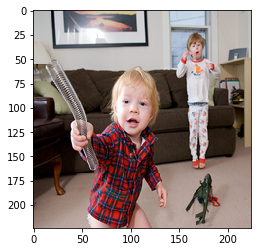

paraglide balck glides glides lay lay lay coasts coasts beat outstretched early moves cot sweashirt calm calm you watercraft peterson spring gowns zepra chains pattern smeared goalkeeper spaghetti same -8.563191690752584
paraglide balck glides glides lay lay lay coasts coasts beat outstretched early moves cot sweashirt calm calm you watercraft peterson spring gowns zepra chains pattern smeared goalkeeper spaghetti same -8.5632050729567
paraglide balck glides glides lay lay lay coasts coasts beat outstretched early moves cot sweashirt calm calm you watercraft peterson spring gowns zepra chains pattern smeared goalkeeper spaghetti same -8.563217316904376


In [17]:
import tensorflow as tf
from tensorflow import keras


captions = generate_caption('D:/Flickr8k/images/2274992140_bb9e868bb8.jpg', VGG_image_size, decoder_model, VGG_transfer_model, train_vocab, )

In [18]:
captions

['paraglide',
 'balck',
 'glides',
 'glides',
 'lay',
 'lay',
 'lay',
 'coasts',
 'coasts',
 'beat',
 'outstretched',
 'early',
 'moves',
 'cot',
 'sweashirt',
 'calm',
 'calm',
 'you',
 'watercraft',
 'peterson',
 'spring',
 'gowns',
 'zepra',
 'chains',
 'pattern',
 'smeared',
 'goalkeeper',
 'spaghetti',
 'same']

In [19]:
images_path = 'D:/Flickr8k/images/'
annotations_path = 'D:/Flickr8k/annotations/'
captions_file = 'D:/Flickr8k/annotations/Flickr8k.token.txt'
train_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.trainImages.txt'
dev_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.devImages.txt'
test_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.testImages.txt'

filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, images_path)

test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, filenames_with_all_captions, images_path)

test_captions = flickr8k_parse.make_list_of_captions(test_filenames_with_all_captions)

In [20]:
test_filenames_with_all_captions.keys()

dict_keys(['D:/Flickr8k/images/3385593926_d3e9c21170.jpg', 'D:/Flickr8k/images/2677656448_6b7e7702af.jpg', 'D:/Flickr8k/images/311146855_0b65fdb169.jpg', 'D:/Flickr8k/images/1258913059_07c613f7ff.jpg', 'D:/Flickr8k/images/241347760_d44c8d3a01.jpg', 'D:/Flickr8k/images/2654514044_a70a6e2c21.jpg', 'D:/Flickr8k/images/2339106348_2df90aa6a9.jpg', 'D:/Flickr8k/images/256085101_2c2617c5d0.jpg', 'D:/Flickr8k/images/280706862_14c30d734a.jpg', 'D:/Flickr8k/images/3072172967_630e9c69d0.jpg', 'D:/Flickr8k/images/3482062809_3b694322c4.jpg', 'D:/Flickr8k/images/1167669558_87a8a467d6.jpg', 'D:/Flickr8k/images/2847615962_c330bded6e.jpg', 'D:/Flickr8k/images/3344233740_c010378da7.jpg', 'D:/Flickr8k/images/2435685480_a79d42e564.jpg', 'D:/Flickr8k/images/3110649716_c17e14670e.jpg', 'D:/Flickr8k/images/2511019188_ca71775f2d.jpg', 'D:/Flickr8k/images/2521770311_3086ca90de.jpg', 'D:/Flickr8k/images/2723477522_d89f5ac62b.jpg', 'D:/Flickr8k/images/2218609886_892dcd6915.jpg', 'D:/Flickr8k/images/3745451546_fc

In [21]:
text_processing.preprocess_captions(test_captions)

In [22]:
references = []
for list_captions in test_captions:
    reference = []
    for caption in list_captions:
        reference.append(caption.split())
    references.append(reference)

In [23]:
references[0]

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [24]:
sentence_bleu(references[0][1:], references[0][0], weights=(0, 0, 0, 1))

D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


1.0

In [25]:
transfer_values = np.load('./cnn_features/vgg16_flickr8k_test.npy')

In [26]:
def generate_test_captions(test_images, *args):
    """
    Generate captions for bunch of validation captions
    """
    captions = []
    for i, image in tqdm(enumerate(test_images)):
        captions.append(generate_caption(image, *args))
 
    return captions

In [27]:
generated_captions = generate_test_captions(transfer_values, VGG_image_size, decoder_model, VGG_transfer_model, train_vocab, True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [28]:
len(generated_captions)

1000

In [29]:
num = 130
generated_captions[num]

['paraglide',
 'glides',
 'glides',
 'glides',
 'recline',
 'recline',
 'lay',
 'lay',
 'tatoo',
 'dirty',
 'patch',
 'visible',
 'film',
 'snuggling',
 'lie',
 'dust',
 'dust',
 'ropes',
 'female',
 'fribee',
 'horseshoe',
 'cracked',
 'dads',
 'harbor',
 'harbor',
 'fishing',
 'perplexed',
 'makes',
 'panhandler']

In [30]:
test_captions[num]

['a little girl hugs another little girl ',
 'a young child is being held by another child looking straight at us ',
 'two toddlers posing for the camera ',
 'two young children holding each other and posing ',
 'two young girls hug ']

In [31]:
test_captions_arr = []
for captions in test_captions:
    tmp_cap_list = []
    for caption in captions:
        tmp_cap_list.append(caption.split())
    test_captions_arr.append(tmp_cap_list)


In [32]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(1,0,0,0)) * 100))

D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.353


In [33]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(0.5,0.5))* 100))

D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


5.943


In [34]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(0.33,0.33,0.33,0)) * 100))

D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


15.518


In [35]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(0.25,0.25,0.25,0.25)) * 100))

D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


24.378
